In [1]:
import pandas as pd
import argparse
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
import os
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler

group = "gangnam_sad"
variable = "LSAS"
smoothness = 6
mdmr_dir = os.path.expanduser("~/fmri_project/C-PAC/CPAC/bcb_mdmr/")
nas_dir = os.path.expanduser("/mnt/NAS2-2/data/")
MDMR_output_dir = f"{nas_dir}/SAD_gangnam_MDMR/"
fmri_prep_dir = f"{nas_dir}/SAD_gangnam_resting_2/fMRIPrep_total"
seed_anal_dir = f"{nas_dir}/SAD_gangnam_seed_based_analysis/"

regressor_df = pd.read_csv(
    f"{mdmr_dir}/input/{group}_{variable}_regressor.csv"
)

subjects_label = regressor_df["Participant"].values
# 필요한 열만 선택하여 디자인 매트릭스 생성

extra_info_subjects = pd.DataFrame({
    "subject_label": subjects_label,
    variable: regressor_df[variable],
    "sex": regressor_df["SEX"],
    "age": regressor_df["AGE"],
    "yr_edu": regressor_df["YR_EDU"],
    "mean_framewise_displacement": regressor_df["Mean_Framewise_Displacement"]
})

# Create a StandardScaler object
scaler = StandardScaler()

# List of columns to normalize
columns_to_normalize = ["age", "yr_edu", variable, "mean_framewise_displacement"]

# Normalize the specified columns
extra_info_subjects[columns_to_normalize] = scaler.fit_transform(extra_info_subjects[columns_to_normalize])

design_matrix = make_second_level_design_matrix(
    subjects_label, extra_info_subjects
)


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.745512495985117' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  design_matrix.loc[ridx, conf_name] = confounds_value
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2635659620320283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  design_matrix.loc[ridx, conf_name] = confounds_value
/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/nilearn/glm/first_level/design_matrix.py:503: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [2]:
design_matrix

,LSAS,sex,age,yr_edu,mean_framewise_displacement,intercept
0,0.745512,0,-1.263566,-1.173074,-0.612170,1
1,-0.070612,0,-1.263566,-1.173074,-0.108372,1
2,0.609492,0,-1.121879,0.093431,-1.030352,1
3,-1.113437,0,0.153300,-1.173074,-0.997298,1
4,-1.022757,1,-0.838506,0.937767,-0.747507,1
...,...,...,...,...,...,...
56,1.198915,0,-0.696819,0.515599,2.707122,1
57,0.926873,1,-0.413446,0.515599,1.908002,1
58,0.110749,0,0.436674,0.093431,0.715341,1
59,-0.115952,0,-0.413446,0.515599,-0.214916,1


In [3]:
z_maps = [f"{seed_anal_dir}/{smoothness}mm/corr_z-map/seed_{group}_{variable}/sub-{subject_id}_fisher_z_img.nii.gz" for subject_id in regressor_df['Participant']]
second_level_model = SecondLevelModel(n_jobs=-1)
second_level_model = second_level_model.fit(
    z_maps,
    design_matrix=design_matrix,
)

In [14]:
p_map = second_level_model.compute_contrast("LSAS",output_type="p_value")
# 대화형 시각화 추가
html_view = plotting.view_img(
    stat_map_img = p_map,
    colorbar=True,
    vmax = 0.05,
    title=f"Interactive P-map for {group} - {variable}"
)

# HTML 파일로 저장
html_view.open_in_browser()


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [19]:
from nilearn import image
import numpy as np
# p-value 맵 계산
p_map = second_level_model.compute_contrast("LSAS", output_type="p_value")

# t-statistic 맵 계산
t_map = second_level_model.compute_contrast("LSAS", output_type="stat")

# p-value 맵에서 0.05 이하인 부분만 마스크 생성
mask_img = image.math_img('img < 0.05', img=p_map)

# 마스크를 적용하여 t-statistic 맵 필터링
masked_t_map = image.math_img('img1 * img2', img1=t_map, img2=mask_img)

t_data = image.get_data(masked_t_map)
t_min = np.min(t_data[t_data != 0])  # 0이 아닌 값 중 최소값
t_max = np.max(t_data)

print(f"Minimum t-value (excluding zeros): {t_min}")
print(f"Maximum t-value: {t_max}")


# 결과 시각화
html_view = plotting.view_img(
    stat_map_img=masked_t_map,
    colorbar=True,
    threshold=0,  # 0 이상의 모든 값 표시 (마스크가 이미 적용되었으므로)
    title=f"Interactive T-map (p<0.05) for {group} - {variable}"
)

# HTML 파일로 저장
html_view.open_in_browser()


Minimum t-value (excluding zeros): 1.6863147795769546
Maximum t-value: 2.787528827809305


/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [21]:
# p-value 맵에서 0.05 이하인 부분만 마스크 생성
positive_t_img = image.math_img('img > 0', img=t_map)

# 마스크를 적용하여 t-statistic 맵 필터링
unmasked_t_img = image.math_img('img1 * img2', img1=t_map, img2=positive_t_img)

In [22]:
masked_t_map.to_filename(f"./{group}_{variable}_masked_tmap.nii.gz")
unmasked_t_img.to_filename(f"./{group}_{variable}_unthresholded_tmap.nii.gz")

In [ ]:
from nilearn import image
import numpy as np
# p-value 맵 계산
p_map = second_level_model.compute_contrast("LSAS", output_type="p_value")

# t-statistic 맵 계산
t_map = second_level_model.compute_contrast("LSAS", output_type="stat")

# p-value 맵에서 0.05 이하인 부분만 마스크 생성
mask_img = image.math_img('img < 0.05', img=p_map)

# 마스크를 적용하여 t-statistic 맵 필터링
masked_t_map = image.math_img('img1 * img2', img1=t_map, img2=mask_img)

t_data = image.get_data(masked_t_map)
t_min = np.min(t_data[t_data != 0])  # 0이 아닌 값 중 최소값
t_max = np.max(t_data)

print(f"Minimum t-value (excluding zeros): {t_min}")
print(f"Maximum t-value: {t_max}")


# 결과 시각화
html_view = plotting.view_img(
    stat_map_img=masked_t_map,
    colorbar=True,
    threshold=0,  # 0 이상의 모든 값 표시 (마스크가 이미 적용되었으므로)
    title=f"Interactive T-map (p<0.05) for {group} - {variable}"
)

# HTML 파일로 저장
html_view.open_in_browser()


In [5]:
from nilearn.glm import threshold_stats_img

thresholded_map1, threshold1 = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=10,
    two_sided=True,
)

html_view = plotting.view_img(
    thresholded_map1,
)

html_view.open_in_browser()

NameError: name 'z_map' is not defined

Coordinates of maximal positive connectivity: [-64.375 -49.625 -19.   ]
Maximum t-value: 2.787528827809305


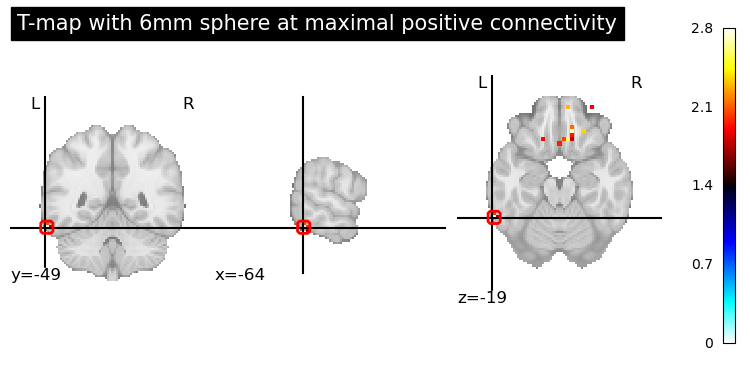

In [27]:
import numpy as np
from nilearn import image, plotting, masking
from scipy import ndimage
t_data = image.get_data(masked_t_map)
max_coord = np.unravel_index(t_data.argmax(), t_data.shape)

# voxel 좌표를 mm 좌표로 변환
affine = masked_t_map.affine
max_coord_mm = np.dot(affine, np.hstack((max_coord, 1)))[:3]

max_t_value = t_data[max_coord]

print(f"Coordinates of maximal positive connectivity: {max_coord_mm}")
print(f"Maximum t-value: {max_t_value}")

# 6mm 반경의 구형 마스크 생성
mask = masking.compute_epi_mask(masked_t_map)
mask_data = image.get_data(mask)
sphere_data = np.zeros_like(mask_data)

vox_coords = np.array(np.where(mask_data)).T
for vox in vox_coords:
    if np.linalg.norm(np.dot(affine, np.hstack((vox, 1)))[:3] - max_coord_mm) <= 6:
        sphere_data[vox[0], vox[1], vox[2]] = 1

sphere = image.new_img_like(masked_t_map, sphere_data)

# 결과 시각화
display = plotting.plot_stat_map(masked_t_map, 
                                 threshold=0, 
                                 cut_coords=max_coord_mm,
                                 title="T-map with 6mm sphere at maximal positive connectivity")

# 구를 그립니다
display.add_contours(sphere, colors='r', levels=[0.5], linewidths=2)

# 대화형 시각화
html_view = plotting.view_img(
    stat_map_img=masked_t_map,
    bg_img=sphere,  # 구를 배경 이미지로 사용
    colorbar=True,
    threshold=0,
    cut_coords=max_coord_mm,
    title=f"T-map with 6mm sphere at maximal positive connectivity\nCoord: {max_coord_mm}\nMax t-value: {max_t_value:.4f}"
)
html_view.open_in_browser()

In [33]:
import numpy as np
from nilearn import image, plotting
from scipy import ndimage
import matplotlib.pyplot as plt
def get_top_n_local_maxima(img, n=5, min_distance=6):
    data = image.get_data(img)
    affine = img.affine
    
    size = np.ceil(min_distance / np.max(np.abs(affine[:3, :3]))).astype(int)
    mask = ndimage.maximum_filter(data, size=size) == data
    mask &= data > 0
    
    coordinates = np.argwhere(mask)
    values = data[mask]
    
    order = np.argsort(values)[::-1]
    top_coordinates = coordinates[order][:n]
    top_values = values[order][:n]
    
    mm_coordinates = np.dot(affine[:3, :3], top_coordinates.T).T + affine[:3, 3]
    
    return mm_coordinates, top_values

# Top 5 local maxima를 찾습니다
top_coords, top_values = get_top_n_local_maxima(masked_t_map, n=5)

# 결과 출력
print("Top 5 local maxima:")
for i, (coord, value) in enumerate(zip(top_coords, top_values), 1):
    print(f"{i}. Coordinate: {coord}, T-value: {value}")

# 각 local maximum에 대해 개별 이미지를 생성합니다
for i, (coord, value) in enumerate(zip(top_coords, top_values), 1):
    # 이미지 생성
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 각 축에 대해 개별적으로 plot_stat_map 호출
    for j, (ax, direction) in enumerate(zip(axes, ['x', 'y', 'z'])):
        display = plotting.plot_stat_map(
            masked_t_map,
            display_mode=direction,
            cut_coords=[coord[j]],  # 해당 좌표를 중심으로 슬라이스 표시
            draw_cross=False,
            threshold=0,
            axes=ax,
            figure=fig
        )
        
        # 동그라미 추가
        ax.add_artist(plt.Circle((0, 0), radius=10, fill=False, color='r', linewidth=2))
    
    # 전체 제목 추가
    fig.suptitle(f"Local Maximum {i}: T-value = {value:.2f}\nCoordinate: {coord}", fontsize=16)
    
    # 이미지 저장
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목을 위한 공간 확보
    plt.savefig(f"local_maximum_{i}.png")
    plt.close()

print("Static images have been saved as 'local_maximum_1.png', 'local_maximum_2.png', etc.")

Top 5 local maxima:
1. Coordinate: [-64.375 -49.625 -19.   ], T-value: 2.787528827809305
2. Coordinate: [ 11.625  34.375 -19.   ], T-value: 2.6961445272302553
3. Coordinate: [  7.625  26.375 -19.   ], T-value: 2.5657658640442365
4. Coordinate: [-12.375  42.375 -27.   ], T-value: 2.465607197801048
5. Coordinate: [-0.375 26.375 -7.   ], T-value: 2.4093460944752123


/tmp/ipykernel_6042/2481208949.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목을 위한 공간 확보


In [70]:
z_map = second_level_model.compute_contrast("LSAS", output_type='z_score')

result_dir = f"{seed_anal_dir}/{smoothness}mm/p_map/{group}/{variable}/result/"
temp_dir = f"{seed_anal_dir}/{smoothness}mm/p_map/{group}/{variable}/temp/"
os.makedirs(result_dir, exist_ok=True)
from nilearn.glm import threshold_stats_img
z_map_filename = f"./unthresholded_z_map.nii.gz"
z_map.to_filename(z_map_filename)

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")
thresholded_map2_filename = f"./FDR_correted_z_map.nii.gz"
thresholded_map2.to_filename(thresholded_map2_filename)

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")
thresholded_map3_filename = f"./bonferroni_correted_z_map.nii.gz"
thresholded_map3.to_filename(thresholded_map3_filename)

The FDR=.05 threshold is 2.44
The p<.05 Bonferroni-corrected threshold is 4.71


In [71]:
p_map = second_level_model.compute_contrast(
    second_level_contrast = "LSAS", 
    output_type='p_value')

p_map_filename = f"./p_value_map.nii.gz"
p_map.to_filename(p_map_filename)

In [59]:
from nilearn.glm.second_level import non_parametric_inference


out_dict = non_parametric_inference(
    z_maps,
    design_matrix=design_matrix,
    second_level_contrast="LSAS",
    n_perm=15000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    n_jobs=-1,
    threshold=0.005,
    verbose=1,
)

Fitting second level model...
Computation of second level model done in 0.17004847526550293 seconds
/home/brain/.conda/envs/gptpred/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/brain/.conda/envs/gptpred/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [61]:
import numpy as np
import nibabel as nib

def threshold_results(out_dict, voxel_threshold=0.005, cluster_threshold=0.05):
    # Get images directly from out_dict
    logp_max_t_img = out_dict['logp_max_t']
    logp_max_size_img = out_dict['logp_max_size']

    # Get data and affine
    logp_max_t_data = logp_max_t_img.get_fdata()
    logp_max_size_data = logp_max_size_img.get_fdata()
    affine = logp_max_t_img.affine

    # Convert -log10(p) to p-values
    voxel_p_values = 10 ** (-logp_max_t_data)
    cluster_p_values = 10 ** (-logp_max_size_data)

    # Calculate -log10(p) thresholds
    voxel_logp_threshold = -np.log10(voxel_threshold)
    cluster_logp_threshold = -np.log10(cluster_threshold)

    # Create masks
    voxel_mask = logp_max_t_data > voxel_logp_threshold
    cluster_mask = logp_max_size_data > cluster_logp_threshold

    # Combine masks
    combined_mask = voxel_mask & cluster_mask

    # Count voxels in each mask
    total_voxels = np.prod(voxel_mask.shape)
    voxel_mask_count = np.sum(voxel_mask)
    cluster_mask_count = np.sum(cluster_mask)
    combined_mask_count = np.sum(combined_mask)

    # Print voxel counts and thresholds
    print(f"총 복셀 수: {total_voxels}")
    print(f"복셀 단위 임계값 (-log10(p) > {voxel_logp_threshold:.4f})을 통과한 복셀 수: {voxel_mask_count}")
    print(f"클러스터 단위 임계값 (-log10(p) > {cluster_logp_threshold:.4f})을 통과한 복셀 수: {cluster_mask_count}")
    print(f"두 임계값을 모두 통과한 복셀 수: {combined_mask_count}")

    # Apply combined mask to voxel-wise -log10(p) values
    final_logp_values = np.where(combined_mask, logp_max_t_data, 0)

    # Create and save the final images
    final_t_img = nib.Nifti1Image(logp_max_t_data, affine)
    final_size_img = nib.Nifti1Image(logp_max_size_data, affine)
    final_combined_img = nib.Nifti1Image(final_logp_values, affine)

    nib.save(final_t_img, 'logp_max_t.nii.gz')
    nib.save(final_size_img, 'logp_max_size.nii.gz')
    nib.save(final_combined_img, 'thresholded_logp_values.nii.gz')

    return final_combined_img

# Usage
thresholded_img = threshold_results(out_dict)

# Print -log10(p) values for p=0.005 and p=0.05
print(f"-log10(0.005) = {-np.log10(0.005):.4f}")
print(f"-log10(0.05) = {-np.log10(0.05):.4f}")

총 복셀 수: 84084
복셀 단위 임계값 (-log10(p) > 2.3010)을 통과한 복셀 수: 0
클러스터 단위 임계값 (-log10(p) > 1.3010)을 통과한 복셀 수: 2357
두 임계값을 모두 통과한 복셀 수: 0
-log10(0.005) = 2.3010
-log10(0.05) = 1.3010


In [ ]:
p_map_filename = "./logp_max_t.nii.gz"
out_dict["logp_max_t"].to_filename(p_map_filename)

p_map_filename = "./logp_max_size.nii.gz"
out_dict["logp_max_size"].to_filename(p_map_filename)

In [52]:
second_level_model = SecondLevelModel(n_jobs=-1)
z_maps = [f"{seed_anal_dir}/{smoothness}mm/corr_z-map/seed_{group}_{variable}/sub-{subject_id}_fisher_z_img.nii.gz" for subject_id in regressor_df['Participant']]

second_level_model = second_level_model.fit(
    z_maps,
    design_matrix=design_matrix,
)

output = second_level_model.compute_contrast(
    second_level_contrast="LSAS",
    output_type="p_value"
)

p_map_filename = "./p_val.nii.gz"
output.to_filename(p_map_filename)

In [65]:
z_map = second_level_model.compute_contrast("LSAS", output_type='z_score')
from nilearn.glm import threshold_stats_img

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold = 0.05
)
print(f"The FDR=.005 threshold is {threshold2:.3g}")
thresholded_map2_filename = "./FDR_correted_z_map.nii.gz"
thresholded_map2.to_filename(thresholded_map2_filename)

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")
thresholded_map3_filename = f"bonferroni_correted_z_map.nii.gz"
thresholded_map3.to_filename(thresholded_map3_filename)

The FDR=.005 threshold is 2.44
The p<.05 Bonferroni-corrected threshold is 4.71


Fitting second level model...
Computation of second level model done in 0.15488076210021973 seconds
/home/brain/.conda/envs/gptpred/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/brain/.conda/envs/gptpred/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [29]:
p_map_filename = "./logp_max_t.nii.gz"
out_dict["logp_max_t"].to_filename(p_map_filename)

In [27]:
p_map_filename = "./logp_max_size.nii.gz"
out_dict["logp_max_size"].to_filename(p_map_filename)

In [16]:
z_map = second_level_model.compute_contrast("LSAS", output_type='z_score')

result_dir = f"{seed_anal_dir}/{smoothness}mm/p_map/{group}/{variable}/result/"
temp_dir = f"{seed_anal_dir}/{smoothness}mm/p_map/{group}/{variable}/temp/"
os.makedirs(result_dir, exist_ok=True)
from nilearn.glm import threshold_stats_img
z_map_filename = f"{result_dir}/unthresholded_z_map.nii.gz"
z_map.to_filename(z_map_filename)

thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")
thresholded_map2_filename = f"{result_dir}/FDR_correted_z_map.nii.gz"
thresholded_map2.to_filename(thresholded_map2_filename)

thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")
thresholded_map3_filename = f"{result_dir}/bonferroni_correted_z_map.nii.gz"
thresholded_map3.to_filename(thresholded_map3_filename)

The FDR=.05 threshold is 2.15
The p<.05 Bonferroni-corrected threshold is 4.71


In [17]:
design_matrix = regressor_df[['SEX', 'AGE', 'YR_EDU', variable, 'Mean_Framewise_Displacement']]

# 인터셉트 열 추가
design_matrix.insert(0, 'intercept', 1)

z_maps = [f"{seed_anal_dir}/{smoothness}mm/corr_z-map/seed_{group}_{variable}/sub-{subject_id}_fisher_z_img.nii.gz" for subject_id in regressor_df['Participant']]

second_level_model = SecondLevelModel(n_jobs=-1)
second_level_model.fit(z_maps, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(args.variable, output_type='z_score')

result_dir = f"{seed_anal_dir}/{args.smoothness}mm/p_map/{args.group}/{args.variable}/result/"
temp_dir = f"{seed_anal_dir}/{args.smoothness}mm/p_map/{args.group}/{args.variable}/temp/"
os.makedirs(result_dir, exist_ok=True)

p_map_filename = f"{result_dir}/pvalue_map.nii.gz"
p_map.to_filename(p_map_filename)

NameError: name 'args' is not defined